In [1]:
import sys
sys.path.append('../')

In [46]:
## CIFAR10 DATASET EVALUATION

import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model
from keras import applications
from keras.utils.np_utils import to_categorical
import numpy as np



from importlib import reload
import libs.analysis as analysis
import libs.load_data as load_data
import libs.cnn_model as cnn_model

In [47]:
base_dir, train_dir, test_dir = load_data.create_folder_paths('../data', '7e716397')
print(base_dir, train_dir, test_dir)

train_patches, test_patches = load_data.read_patch_files(base_dir)
display(train_patches.head())

../data/7e716397 ../data/7e716397/train ../data/7e716397/test


Unnamed: 0                              image_id  \
0           0  0734bb2a-57dd-4510-9187-c01c860f7a89   
1           1  0734bb2a-57dd-4510-9187-c01c860f7a89   
2           2  0734bb2a-57dd-4510-9187-c01c860f7a89   
3           3  0734bb2a-57dd-4510-9187-c01c860f7a89   
4           4  0734bb2a-57dd-4510-9187-c01c860f7a89   

                             contour_id          patch_id  \
0  e1bb92db-a922-48cd-95d7-b621fb57e665  UBP2mbda2UTosTd7   
1  e1bb92db-a922-48cd-95d7-b621fb57e665  kdGkWKTBKEhSSXG8   
2  e1bb92db-a922-48cd-95d7-b621fb57e665  gvmrNz2RGgCCSHJs   
3  e1bb92db-a922-48cd-95d7-b621fb57e665  g7X5NTiW8F7RGANL   
4  e1bb92db-a922-48cd-95d7-b621fb57e665  fi9usoBZYSPBpLcW   

              patch_name    x    y  label_id  
0  UBP2mbda2UTosTd7.jpeg   54  233         3  
1  kdGkWKTBKEhSSXG8.jpeg   86  233         3  
2  gvmrNz2RGgCCSHJs.jpeg  118  233         3  
3  g7X5NTiW8F7RGANL.jpeg  150  233         3  
4  fi9usoBZYSPBpLcW.jpeg  182  233         3

In [48]:
train_images, train_labels = load_data.load_data(train_patches, train_dir)
test_images, test_labels = load_data.load_data(test_patches, test_dir)
print(train_images.shape)
print(test_images.shape)

(1981, 64, 64, 3)
(906, 64, 64, 3)


In [49]:
patch_size = 64

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (patch_size, patch_size, 3))


In [50]:
for layer in model.layers[1:7]:
    #print(layer)
    layer.trainable = False
    
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [55]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [51]:
# Parameters
batch_size = 64
epochs = 10
num_classes = 4

# Model Destination
model_dest_file = 'transfer_learning_t1.h5'

In [52]:
# Normalization
def mean_subtraction(data):
    mean_img = np.mean(data, axis=0)
    std_img = np.std(data, axis=0)
    return mean_img, std_img
    
img_mean, img_stdev = mean_subtraction(train_images)

train_images -= img_mean
train_images /= img_stdev
test_images -= img_mean
test_images /= img_stdev

In [53]:
train_labels -= 1
test_labels -= 1

train_labels_oh = to_categorical(train_labels)
test_labels_oh = to_categorical(test_labels)

In [ ]:
# if we're loading a model load it!
model_final = load_model(model_dest_file)

In [57]:
# Fit i.e. train the model
history = model_final.fit(train_images, train_labels_oh, batch_size=batch_size, epochs=epochs,
                      verbose=1, validation_data=(test_images, test_labels_oh))

Train on 1981 samples, validate on 906 samples
Epoch 1/10
1981/1981 [==============================] - 393s 199ms/step - loss: 1.2507 - acc: 0.4922 - val_loss: 1.8337 - val_acc: 0.1545
Epoch 2/10
1981/1981 [==============================] - 407s 206ms/step - loss: 1.1243 - acc: 0.5618 - val_loss: 1.7345 - val_acc: 0.1545
Epoch 3/10
1981/1981 [==============================] - 412s 208ms/step - loss: 1.0561 - acc: 0.5785 - val_loss: 1.6358 - val_acc: 0.1843
Epoch 4/10
1981/1981 [==============================] - 415s 210ms/step - loss: 0.9911 - acc: 0.6037 - val_loss: 1.4229 - val_acc: 0.3245
Epoch 5/10
1981/1981 [==============================] - 408s 206ms/step - loss: 0.9325 - acc: 0.6345 - val_loss: 1.3873 - val_acc: 0.4205
Epoch 6/10
1981/1981 [==============================] - 413s 208ms/step - loss: 0.8308 - acc: 0.6830 - val_loss: 1.2464 - val_acc: 0.5044
Epoch 7/10
1981/1981 [==============================] - 442s 223ms/step - loss: 0.7499 - acc: 0.7390 - val_loss: 1.3806 - val

In [62]:
# Save the model data
model_final.save(model_dest_file)

In [64]:
# Now Let's evaluate the model
score = model_final.evaluate(test_images, test_labels_oh, verbose=0)

In [65]:
# View the Final Loss and Accuracy scores across all epochs
analysis.print_loss_and_accuracy_from_score(score)

Test loss: 1.5372409396876825
Test accuracy: 0.4094922738622619


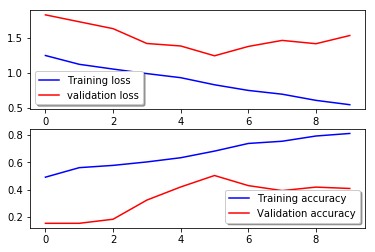

In [66]:
# View the Loss and Accuracy curves across the epochs
analysis.plot_loss_and_accuracy_curves(history, save=True)

In [68]:
reload(analysis)
y_pred = model.predict(test_images)

[[[[4.7481422  0.         0.         ... 0.         1.1798936
    0.        ]
   [4.3552527  0.         0.         ... 0.         0.45614696
    0.        ]]

  [[0.8853144  0.         0.         ... 0.         2.2441053
    0.        ]
   [0.03968817 0.         0.         ... 0.         1.5437531
    0.        ]]]


 [[[2.0644858  0.         0.         ... 0.         0.5425776
    0.        ]
   [1.3357701  0.         0.         ... 0.         0.42198294
    0.        ]]

  [[0.         0.         0.         ... 0.         1.6953297
    0.        ]
   [0.         0.         0.         ... 0.         0.560307
    0.        ]]]


 [[[2.5085137  0.         0.         ... 0.         0.87423354
    0.        ]
   [2.895941   0.         0.         ... 0.         1.0921404
    0.        ]]

  [[0.         0.         0.         ... 0.         1.6636529
    0.        ]
   [0.         0.         0.         ... 0.         1.1450467
    0.        ]]]


 ...


 [[[5.1170607  0.         0.         

In [91]:
reload(analysis)

res = np.argmax(y_pred.reshape(906, 4, 512), axis=1)
print(len(test_labels))

# analysis.plot_confusion_matrix_clean(test_labels, y_pred, classes=range(4), save=True)

906
512


In [72]:
reload(analysis)
analysis.print_metrics(test_labels_oh, y_pred)

ValueError: Classification metrics can't handle a mix of multiclass and unknown targets